# Generate User-Course Interactions

This notebook generates synthetic user enrollments in courses based on their interests and skills.

In [11]:
import pandas as pd
import numpy as np
import ast
import random
from datetime import datetime, timedelta
import json

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Load Data

In [12]:
# Load cluster-based users
users_df = pd.read_csv('../data/processed/synth_users.csv')
print(f"Loaded {len(users_df)} users")
print(users_df.head())

# Load cleaned courses
courses_df = pd.read_csv('../data/processed/coursera_cleaned.csv')
print(f"\nLoaded {len(courses_df)} courses")
print(courses_df.head())

Loaded 400 users
   user_id                                             skills  \
0        0  ['writing', 'regression', 'natural language pr...   
1        1  ['authentication', 'digital signature', 'softw...   
2        2  ['informatics', 'cloud computing', 'databases'...   
3        3  ['principle', 'trading', 'process', 'game desi...   
4        4  ['object-oriented programming', 'software', 'i...   

       experience_levels                                        skills_text  \
0        [5, 3, 3, 4, 2]  writing  regression  natural language processi...   
1        [3, 3, 4, 3, 2]  authentication  digital signature  software en...   
2     [3, 4, 4, 4, 3, 2]  informatics  cloud computing  databases  sql  ...   
3  [5, 4, 3, 2, 3, 3, 1]  principle  trading  process  game design  natu...   
4        [4, 3, 3, 1, 2]  object-oriented programming  software  i-deas ...   

   num_skills primary_clusters  avg_experience  
0           5           [2, 1]        3.400000  
1           5      

## Define Skill Matching Functions

In [13]:
def parse_skills(skills_str):
    """Convert string representation of list to actual list"""
    try:
        return ast.literal_eval(skills_str)
    except:
        return []

def calculate_skill_overlap(user_skills, user_experience, course_skills_str):
    """
    Calculate weighted skill overlap between user and course.
    Prioritizes user's high-experience skills (level 4-5).
    """
    if pd.isna(course_skills_str) or course_skills_str.strip() == '':
        return 0, 0
    
    course_skills = [s.strip().lower() for s in course_skills_str.split('  ')]
    
    # Create skill-experience mapping
    skill_exp_map = {str(skill).lower(): exp for skill, exp in zip(user_skills, user_experience)}
    
    # Count overlapping skills
    overlap_count = 0
    weighted_overlap = 0
    
    for course_skill in course_skills:
        if course_skill in skill_exp_map:
            overlap_count += 1
            # Weight by experience level (4-5 = high expertise)
            exp_level = skill_exp_map[course_skill]
            weighted_overlap += exp_level / 5.0  # Normalize to 0-1
    
    return overlap_count, weighted_overlap

def get_course_categories(courses_df, user_skills, user_experience, num_user_skills):
    """
    Categorize courses into three groups based on skill overlap and experience:
    - High match: courses matching user's primary (high-experience) skills
    - Low match: courses with at most 1 skill overlap
    - Random: all other courses
    """
    high_match = []
    low_match = []
    random_pool = []
    
    # Lower threshold for more high matches: 2 skills or 30% overlap
    min_skills = max(2, int(num_user_skills * 0.3))
    
    for idx, row in courses_df.iterrows():
        overlap_count, weighted_overlap = calculate_skill_overlap(
            user_skills, user_experience, row['skills_cleaned']
        )
        
        # High match: at least min_skills overlap OR high weighted overlap
        if overlap_count >= min_skills or weighted_overlap >= 1.5:
            high_match.append(idx)
        elif overlap_count <= 1:
            low_match.append(idx)
        else:
            random_pool.append(idx)
    
    return high_match, low_match, random_pool

print("Functions defined successfully!")

Functions defined successfully!


## Generate User Enrollments

For each user, we will:
1. Determine number of courses to enroll in (4-12)
2. Allocate courses based on distribution:
   - 10% random courses
   - 80% high-match courses (most skills overlap)
   - 10% low-match courses (at most 1 skill overlap)

In [14]:
def generate_enrollments_for_user(user_row, courses_df):
    """
    Generate course enrollments for a single user with ratings.
    
    Distribution:
    - 10% random courses
    - 80% high-match courses (most skills overlap)
    - 10% low-match courses (at most 1 skill overlap)
    
    Ratings based on match quality:
    - High match: 3.5-5.0 (mean=4.3, std=0.4)
    - Random: 1.5-4.0 (mean=3.0, std=0.7)
    - Low match: 1.0-3.0 (mean=2.3, std=0.6)
    """
    user_id = user_row['user_id']
    user_skills = parse_skills(user_row['skills'])
    user_experience = parse_skills(user_row['experience_levels'])
    num_user_skills = len(user_skills)
    
    # Determine number of courses (4-12)
    num_courses = random.randint(4, 12)
    
    # Calculate distribution
    num_random = max(1, int(num_courses * 0.10))
    num_low_match = max(1, int(num_courses * 0.10))
    num_high_match = num_courses - num_random - num_low_match
    
    # Get course categories (now using experience levels)
    high_match, low_match, random_pool = get_course_categories(
        courses_df, user_skills, user_experience, num_user_skills
    )
    
    # If not enough courses in a category, adjust
    if len(high_match) < num_high_match:
        # Move excess to random pool
        deficit = num_high_match - len(high_match)
        num_high_match = len(high_match)
        num_random += deficit
    
    if len(low_match) < num_low_match:
        # Move excess to random pool
        deficit = num_low_match - len(low_match)
        num_low_match = len(low_match)
        num_random += deficit
    
    enrollments = []
    
    # Select high-match courses
    if num_high_match > 0 and len(high_match) > 0:
        selected_high = random.sample(high_match, min(num_high_match, len(high_match)))
        for course_idx in selected_high:
            rating = np.clip(np.random.normal(4.3, 0.4), 1.0, 5.0)
            enrollments.append({
                'user_id': user_id,
                'course_index': course_idx,
                'course_name': courses_df.iloc[course_idx]['Course Name'],
                'match_type': 'high',
                'rating': round(rating, 2)
            })
    
    # Select low-match courses
    if num_low_match > 0 and len(low_match) > 0:
        selected_low = random.sample(low_match, min(num_low_match, len(low_match)))
        for course_idx in selected_low:
            rating = np.clip(np.random.normal(2.3, 0.6), 1.0, 5.0)
            enrollments.append({
                'user_id': user_id,
                'course_index': course_idx,
                'course_name': courses_df.iloc[course_idx]['Course Name'],
                'match_type': 'low',
                'rating': round(rating, 2)
            })
    
    # Select random courses (from all courses not yet selected)
    all_courses = set(range(len(courses_df)))
    already_selected = set([e['course_index'] for e in enrollments])
    available_random = list(all_courses - already_selected)
    
    if num_random > 0 and len(available_random) > 0:
        selected_random = random.sample(available_random, min(num_random, len(available_random)))
        for course_idx in selected_random:
            rating = np.clip(np.random.normal(3.0, 0.7), 1.0, 5.0)
            enrollments.append({
                'user_id': user_id,
                'course_index': course_idx,
                'course_name': courses_df.iloc[course_idx]['Course Name'],
                'match_type': 'random',
                'rating': round(rating, 2)
            })
    
    return enrollments

print("Enrollment generation function defined!")

Enrollment generation function defined!


## Generate All User Enrollments

In [15]:
# Generate enrollments for all users
all_enrollments = []

for idx, user_row in users_df.iterrows():
    user_enrollments = generate_enrollments_for_user(user_row, courses_df)
    all_enrollments.extend(user_enrollments)
    
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(users_df)} users")

print(f"\nGenerated {len(all_enrollments)} total enrollments")
print(f"Average enrollments per user: {len(all_enrollments) / len(users_df):.2f}")

# Convert to DataFrame
enrollments_df = pd.DataFrame(all_enrollments)
print(f"\nEnrollments DataFrame shape: {enrollments_df.shape}")
print(enrollments_df.head(10))

Processed 100/400 users
Processed 200/400 users
Processed 300/400 users
Processed 400/400 users

Generated 3280 total enrollments
Average enrollments per user: 8.20

Enrollments DataFrame shape: (3280, 5)
   user_id  course_index                                        course_name  \
0        0           375                   Introduction to Machine Learning   
1        0          1330       Merge, Sort and Filter Data in Python Pandas   
2        0          1810                        Introduction to Google Docs   
3        0           916     Perform Real-Time Object Detection with YOLOv3   
4        0           572          TensorFlow for AI: Computer Vision Basics   
5        1           199               Software Product Management Capstone   
6        1          2084  Agile Projects: Develop Product Wireframe Prot...   
7        1          1034        Introduction to Software Product Management   
8        1           130                 Introduction to Acoustics (Part 2)   
9    

## Analyze Enrollment Statistics

In [16]:
# Distribution of match types
print("=== Match Type Distribution ===")
match_distribution = enrollments_df['match_type'].value_counts()
match_percentage = enrollments_df['match_type'].value_counts(normalize=True) * 100
print(pd.DataFrame({
    'Count': match_distribution,
    'Percentage': match_percentage.round(2)
}))

print("\n=== Rating Statistics by Match Type ===")
rating_stats = enrollments_df.groupby('match_type')['rating'].agg(['count', 'mean', 'std', 'min', 'max'])
print(rating_stats.round(3))

print("\n=== Overall Rating Statistics ===")
print(f"Mean Rating: {enrollments_df['rating'].mean():.3f}")
print(f"Std Rating: {enrollments_df['rating'].std():.3f}")
print(f"Min Rating: {enrollments_df['rating'].min():.3f}")
print(f"Max Rating: {enrollments_df['rating'].max():.3f}")

=== Match Type Distribution ===
            Count  Percentage
match_type                   
high         1878       57.26
random       1002       30.55
low           400       12.20

=== Rating Statistics by Match Type ===
            count   mean    std  min   max
match_type                                
high         1878  4.299  0.381  3.0  5.00
low           400  2.327  0.624  1.0  4.61
random       1002  3.031  0.675  1.0  5.00

=== Overall Rating Statistics ===
Mean Rating: 3.671
Std Rating: 0.917
Min Rating: 1.000
Max Rating: 5.000


In [17]:
# Enrollments per user distribution
enrollments_per_user = enrollments_df.groupby('user_id').size()
print("\n=== Enrollments per User ===")
print(f"Min: {enrollments_per_user.min()}")
print(f"Max: {enrollments_per_user.max()}")
print(f"Mean: {enrollments_per_user.mean():.2f}")
print(f"Median: {enrollments_per_user.median():.2f}")

# Most popular courses
print("\n=== Top 10 Most Enrolled Courses ===")
top_courses = enrollments_df['course_name'].value_counts().head(10)
for idx, (course, count) in enumerate(top_courses.items(), 1):
    print(f"{idx}. {course[:60]}... - {count} enrollments")


=== Enrollments per User ===
Min: 4
Max: 12
Mean: 8.20
Median: 8.00

=== Top 10 Most Enrolled Courses ===
1. Getting Started with AI using IBM Watson... - 8 enrollments
2. Google Cloud Platform Fundamentals for AWS Professionals... - 7 enrollments
3. RPA Lifecycle: Deployment and Maintenance... - 6 enrollments
4. Regression Analysis with Yellowbrick... - 6 enrollments
5. Creating and Developing a Tech Startup... - 6 enrollments
6. Data Management and Visualization... - 6 enrollments
7. Launch Strategy: 5 Steps to Capstone Experience... - 6 enrollments
8. Agile Planning for Software Products... - 6 enrollments
9. Foundations for Global Health Responders... - 6 enrollments
10. Compose and Program Music in Python using Earsketch... - 6 enrollments


## Visualize Rating Distributions

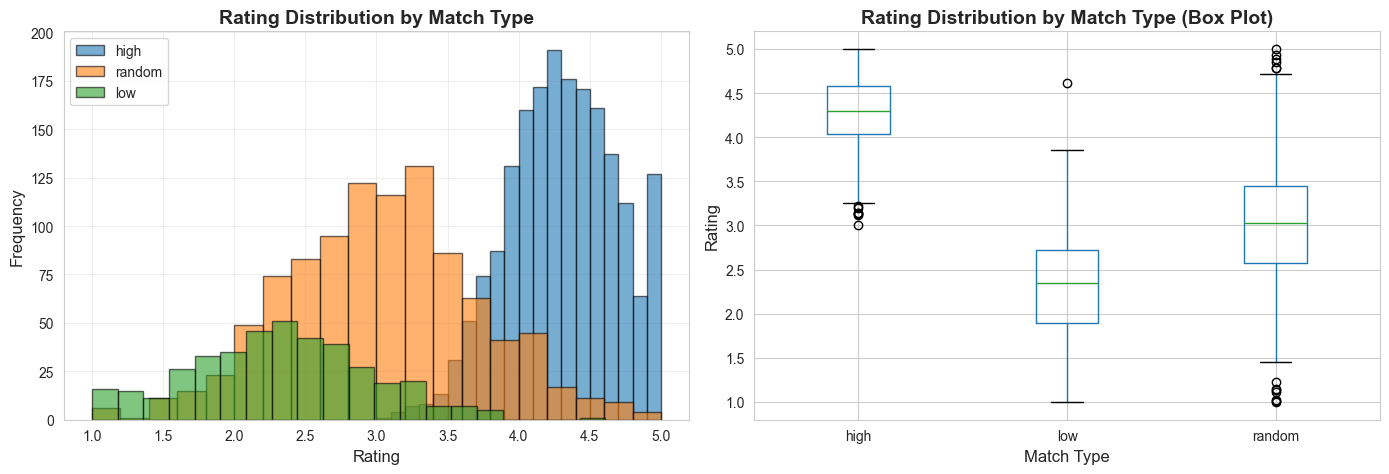

Rating distributions visualized!


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Rating distribution by match type
for match_type in ['high', 'random', 'low']:
    data = enrollments_df[enrollments_df['match_type'] == match_type]['rating']
    axes[0].hist(data, alpha=0.6, bins=20, label=match_type, edgecolor='black')

axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Rating Distribution by Match Type', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Box plot of ratings by match type
enrollments_df.boxplot(column='rating', by='match_type', ax=axes[1])
axes[1].set_xlabel('Match Type', fontsize=12)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Distribution by Match Type (Box Plot)', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove the automatic title

plt.tight_layout()
plt.show()

print("Rating distributions visualized!")

## Save Enrollment Data

In [19]:
# Save enrollments to CSV
output_path = '../data/processed/user_course_enrollments.csv'
enrollments_df.to_csv(output_path, index=False)
print(f"Saved enrollments to {output_path}")

# Also save metadata
metadata = {
    'generation_date': datetime.now().isoformat(),
    'total_users': len(users_df),
    'total_courses': len(courses_df),
    'total_enrollments': len(enrollments_df),
    'avg_enrollments_per_user': float(len(enrollments_df) / len(users_df)),
    'distribution': {
        'high_match_target': '80%',
        'random_target': '10%',
        'low_match_target': '10%',
        'high_match_actual': f"{(match_distribution.get('high', 0) / len(enrollments_df) * 100):.2f}%",
        'random_actual': f"{(match_distribution.get('random', 0) / len(enrollments_df) * 100):.2f}%",
        'low_match_actual': f"{(match_distribution.get('low', 0) / len(enrollments_df) * 100):.2f}%"
    },
    'rating_stats': {
        'overall_mean': float(enrollments_df['rating'].mean()),
        'overall_std': float(enrollments_df['rating'].std()),
        'high_match_mean': float(enrollments_df[enrollments_df['match_type'] == 'high']['rating'].mean()),
        'random_mean': float(enrollments_df[enrollments_df['match_type'] == 'random']['rating'].mean()),
        'low_match_mean': float(enrollments_df[enrollments_df['match_type'] == 'low']['rating'].mean())
    },
    'enrollments_per_user': {
        'min': int(enrollments_per_user.min()),
        'max': int(enrollments_per_user.max()),
        'mean': float(enrollments_per_user.mean()),
        'median': float(enrollments_per_user.median())
    }
}

metadata_path = '../data/processed/enrollment_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to {metadata_path}")

print("\n=== Generation Complete ===")
print(f"Total enrollments: {len(enrollments_df)}")
print(f"Users: {len(users_df)}")
print(f"Courses: {len(courses_df)}")
print(f"Average enrollments per user: {len(enrollments_df) / len(users_df):.2f}")

Saved enrollments to ../data/processed/user_course_enrollments.csv
Saved metadata to ../data/processed/enrollment_metadata.json

=== Generation Complete ===
Total enrollments: 3280
Users: 400
Courses: 3408
Average enrollments per user: 8.20


## Sample of Generated Enrollments

Let's look at a sample user and their enrolled courses:

In [20]:
# Sample a random user
sample_user_id = random.choice(users_df['user_id'].tolist())
sample_user = users_df[users_df['user_id'] == sample_user_id].iloc[0]
sample_enrollments = enrollments_df[enrollments_df['user_id'] == sample_user_id]

print(f"=== Sample User {sample_user_id} ===")
print(f"Skills: {sample_user['skills_text']}")
print(f"Number of skills: {sample_user['num_skills']}")
print(f"Average experience: {sample_user['avg_experience']:.2f}")
print(f"Primary clusters: {sample_user['primary_clusters']}")
print(f"\n=== Enrolled Courses ({len(sample_enrollments)} courses) ===\n")

for idx, enroll in sample_enrollments.iterrows():
    course_info = courses_df.iloc[enroll['course_index']]
    print(f"{enroll['match_type'].upper()} MATCH - Rating: {enroll['rating']}")
    print(f"  Course: {enroll['course_name']}")
    print(f"  Skills: {course_info['skills_cleaned']}")
    print(f"  Difficulty: {course_info['Difficulty Level']}")
    print()

=== Sample User 369 ===
Skills: art  strategy  microsoft excel  inventory
Number of skills: 4
Average experience: 3.00
Primary clusters: [2, 0]

=== Enrolled Courses (6 courses) ===

HIGH MATCH - Rating: 4.22
  Course: Art & Activity: Interactive Strategies for Engaging with Art
  Skills: art history  teaching  art  strategy  history  methodology  photography  analysis
  Difficulty: Advanced

HIGH MATCH - Rating: 4.54
  Course: Leading Innovation in Arts and Culture
  Skills: innovation  strategy  thought  creativity  market (economics)  art  experience  collaboration
  Difficulty: Advanced

HIGH MATCH - Rating: 4.36
  Course: Supply Chain Management: A Learning Perspective
  Skills: supply chain  inventory  supply chain management  strategy  chaining  global  process
  Difficulty: Beginner

HIGH MATCH - Rating: 4.07
  Course: Accessibility to the Scenic Arts
  Skills: entry point  adaptation  cost  strategy  art  target audience
  Difficulty: Beginner

LOW MATCH - Rating: 2.43
  Cours